# Entity embedding using PCA and Kernel PCA

In the [previous notebook](spectral-encoding-of-categorical-features.ipynb) on this topic we introduced a way to learn categorical feature embedding based on the similarity of the categorical feature values. To remind you, the problem we are trying to solve is that it is difficult to find a good mapping (or embedding) of the categorical feature variables into a vector space. The usual approach of 1-hot encoding results in many additional columns, and the categorical feature has too much influence on the model, reducing its ability to generalize. Ordinal encoding, from the other hand, does not increase the number of columns, but, if incorrectly chosen, reduces the linear separability of the data, and hurts the model performance. 

The ideal categorical feature embedding would avoid creating too many new columns, but from the other hand preserve linear separability of the majority of data. One approach is to use entity embedding layer into the neural network that works on the tabular data. In the [previous notebook](spectral-encoding-of-categorical-features.ipynb) we proposed using spectral graph theory to find the best embedding of a categorical feature. However that approach uses only category similarity, and does not use the probability distribution of categories. But from our experience we know that the probability distribution of the categories plays a very important role in finding the optimal embedding. For example, if several categories have very few records, it makes sense to bin them into a single value "other", because that will reduce the number of columns and will not hurt the model performance much. 

One way to automate this decision is to use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) algorithm, or a similar algorithm [MCA](https://en.wikipedia.org/wiki/Multiple_correspondence_analysis). The idea is to use PCA after 1-hot encoding done (with MCA an additional transformation is required). Picking the highest-eigenvalue vectors, we can represent categories in a low dimensional vector space. PCA will position high-frequency categories far apart, but will put low-frequency categories close together. Let's demonstrate it on the artificial example. As before, we consider a day of the week feature, where 0 is Monday and 6 correspond to Sunday. Imagine that most of the data come on the weekend, so we will create an synthetic  data set to demonstrate our concept.

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=200)

In [2]:
random_data = np.random.random((1000,7))
#The next line makes weekend much more likely
random_data *= np.array([1,1,1,1,1,6,6]).reshape(1, -1) * random_data
one_hot_encoded = (random_data == random_data.max(axis=1).reshape(-1, 1)).astype('int')
one_hot_encoded.sum(axis=0)

array([ 23,  21,  23,  19,  20, 456, 438])

We see that Saturday and Sunday have much more data than the weekdays. We will fit PCA on this categorical variable, but leave only two components with the highest eigenvalues (i.e. those that capture most variance)

In [3]:
from sklearn.decomposition import PCA
model = PCA(n_components=2).fit(one_hot_encoded)

Let's plot the components to see how the categories are mapped into two-dimensional vector space:

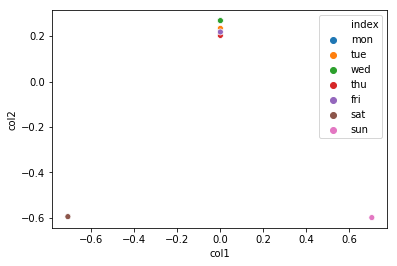

In [4]:
%matplotlib inline
import seaborn as sns
category_vectors = model.components_.T
category_vector_frame=pd.DataFrame(category_vectors, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2', hue='index');

We can see that the vectors for Sunday and Saturday are far apart from each other, but also far apart from the rest of the days of the week (Monday and Thursday have the same vectors, so they are marked with one point in the plot).

Our methodology then is to do the PCA analysis on each categorical variable, and not on the entire data set. This strategy is justified if the categorical variables are relatively independent (we should always do dependency test during feature engineering). If there is strong dependency between two categorical variables, then we can lo longer represent the joined probability distribution of these variables as a product of two Categorical distributions. In this case we will have to do a 1-hot encoding and PCA on the combinations of two categories, which will provide poor results if there are many combinations with few or none of the observations.

## Kernel PCA

Here we will develop the idea we proposed in the previous work, that is to use the category similarity function to influence the category embedding. For this we can use a well known method called [Kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis), and the kernel function will be represented as a symmetric matrix. Please note that the kernel matrix has to be [positively defined](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix).

Similar to the previous notebook, let's make Saturday and Sunday dissimilar from the weekdays, and let's see how that influences the category embedding:

In [5]:
kernel_matrix = np.array([[.5, 0.9, 0.8, 0.7, 0.5, 0.1, 0.3], 
                        [0, .5, 0.9, 0.8, 0.5, 0.1, 0.2],
                        [0,0,.5,0.9, 0.5, 0.1, 0.2], 
                        [0,0,0,.5,.6, .1, .2], 
                        [0,0,0,0,.5,0.7,.5], 
                        [0,0,0,0,0,.5,.8],
                        [0,0,0,0,0,0,.5]])
kernel_matrix = kernel_matrix + kernel_matrix.T
kernel_matrix

array([[1. , 0.9, 0.8, 0.7, 0.5, 0.1, 0.3],
       [0.9, 1. , 0.9, 0.8, 0.5, 0.1, 0.2],
       [0.8, 0.9, 1. , 0.9, 0.5, 0.1, 0.2],
       [0.7, 0.8, 0.9, 1. , 0.6, 0.1, 0.2],
       [0.5, 0.5, 0.5, 0.6, 1. , 0.7, 0.5],
       [0.1, 0.1, 0.1, 0.1, 0.7, 1. , 0.8],
       [0.3, 0.2, 0.2, 0.2, 0.5, 0.8, 1. ]])

In [6]:
def kernel_function(x1, x2):
    return x1.T @ kernel_matrix @ x2

In [7]:
from sklearn.decomposition.kernel_pca import KernelPCA
algorithm = KernelPCA(n_components=2, kernel=kernel_function)
model = algorithm.fit(one_hot_encoded)

In [8]:
transformed = model.transform(np.diag(np.ones((7))))

array([[ 1.03305649, -0.19636025],
       [ 1.05001289, -0.38425859],
       [ 1.0480194 , -0.38846218],
       [ 1.01195609, -0.38461521],
       [ 0.29211243, -0.54331321],
       [-0.25333403, -0.22797924],
       [ 0.04688558,  0.32797451]])

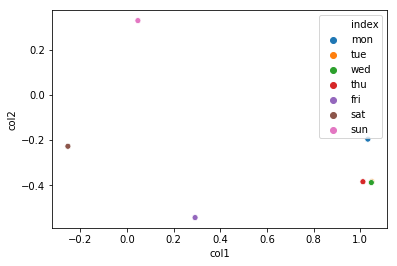

In [10]:
category_vectors = transformed
category_vector_frame=pd.DataFrame(category_vectors, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2', hue='index')
transformed

We can see here that the weekdays are separated further apart, except Tuesday and  Wednesday, which have almost the same value (and represented on the plot with one point).

## Conclusion
We see that kernel categorical embedding can be improved by using PCA instead of the Laplacian formulation. Just using PCA for a single categorical variable is very useful, because it allows map the categories into a low dimensional vector space without sacrificing linear separability. When enhanced on the notion of categorical similarity, it becomes possible to apply Kernel PCA to capture both the probability distribution and the similarity of the categories, which improves linear separability even further. 

There are several ways to define the kernel function. If it is unknown *a priori*, it can be derived from the data by measuring the Wasserstein distance between the probability distribution of the data given the category values, then, for example, take a negative exponential function to get a positively defined matrix:

$$ K(i, j) = exp( - \gamma * W(i, j))$$